# Linear VMM (Vessel Maneuvering Model) for wPCC using brix coefficients

# Purpose
Implementing according to:
Matusiak, Jerzy. Dynamics of a Rigid Ship. Aalto University, 2017. https://aaltodoc.aalto.fi:443/handle/123456789/24408.

# Methodology
Define the problem using SymPy

# Setup

In [1]:
# %load imports.py
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False  ## (To fix autocomplete)

## External packages:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)

import numpy as np
import os
import matplotlib.pyplot as plt

import plotly.express as px 
import plotly.graph_objects as go

import seaborn as sns
import sympy as sp
from sympy.physics.mechanics import (dynamicsymbols, ReferenceFrame,
                                      Particle, Point)
from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex
from src.substitute_dynamic_symbols import run, lambdify

import pyro

import sklearn
import pykalman
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm

from scipy.integrate import solve_ivp

## Local packages:
from src.data import mdl
from src import symbols
from src import prime_system
from src.symbols import *
from src.linear_vmm_equations import *

import src.linear_vmm_equations as eq
import src.models.linear_vmm as model
from src.visualization.plot import track_plot
import src.nonlinear_vmm_equations as nonlinear_vmm_equations


Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


## Load test

In [2]:
df_runs = mdl.runs()

In [3]:
#id=22773
#id=22616
#id=22774
id=22770


df, units, meta_data = mdl.load(id=id, dir_path='../data/processed/kalman')
df.index = df.index.total_seconds()
df = df.iloc[0:-100].copy()
df.index-=df.index[0]
df.sort_index(inplace=True)

In [4]:
meta_data['rho']=1000
meta_data['mass'] = meta_data['Volume']*meta_data['rho']
meta_data.dropna()

A0                                                               0.722775
KXX                                                              0.331311
KZZ                                                              1.253641
TA                                                               0.206311
TF                                                               0.206311
Volume                                                           0.441027
angle1                                                               10.0
angle2                                                               10.0
beam                                                             0.946602
comment                                                        ZZ 10/10PS
date                                                           2020-09-24
facility                                                              MDL
file_path_hdf5          \\sspa.local\lab\MeasuredataMDL\40199079\005\0...
gm                                    

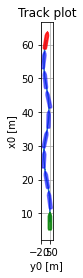

In [5]:
from src.visualization.plot import track_plot
fig,ax=plt.subplots()
#fig.set_size_inches(10,10)
track_plot(df=df, lpp=meta_data.lpp, x_dataset='x0', y_dataset='y0',  psi_dataset='psi', beam=meta_data.beam, ax=ax);

# Ship parameters

In [6]:
T_ = (meta_data.TA + meta_data.TF)/2
L_ = meta_data.lpp
m_ = meta_data.mass
rho_ = meta_data.rho
B_ = meta_data.beam
CB_ = m_/(T_*B_*L_*rho_)
I_z_ = m_*meta_data.KZZ**2

ship_parameters = {
        'T' : T_,
        'L' : L_,
        'CB' :CB_,
        'B' : B_,
        'rho' : rho_,
        'x_G' : 0,  # motions are expressed at CG
        'm' : m_,
        'I_z': I_z_, 
    }

ps = prime_system.PrimeSystem(**ship_parameters)


# Brix parameters

In [33]:
def calculate_prime(row, ship_parameters):
    return run(function=row['brix_lambda'], inputs=ship_parameters)

mask = df_parameters['brix_lambda'].notnull()
df_parameters.loc[mask,'prime'] = df_parameters.loc[mask].apply(calculate_prime, ship_parameters=ship_parameters, axis=1)
df_parameters.loc['Ydelta','prime'] = 0.005  # Just guessing
df_parameters.loc['Ndelta','prime'] = -df_parameters.loc['Ydelta','prime']/2  # Just guessing
df_parameters['prime'].fillna(0, inplace=True)

In [34]:
df_parameters

,coord,dof,state,symbol,brix,brix_lambda,prime
Xu,u,X,,X_{u},NaN,NaN,0.000000
Xudot,u,X,dot,X_{\dot{u}},NaN,NaN,0.000000
Xv,v,X,,X_{v},NaN,NaN,0.000000
Xvdot,v,X,dot,X_{\dot{v}},NaN,NaN,0.000000
Xr,r,X,,X_{r},NaN,NaN,0.000000
Xrdot,r,X,dot,X_{\dot{r}},NaN,NaN,0.000000
Xdelta,\delta,X,,X_{\delta},NaN,NaN,0.000000
Xdeltadot,\delta,X,dot,X_{\dot{\delta}},NaN,NaN,0.000000
Yu,u,Y,,Y_{u},NaN,NaN,0.000000
Yudot,u,Y,dot,Y_{\dot{u}},NaN,NaN,0.000000


In [35]:
ship_parameters

{'T': 0.2063106796116504,
 'L': 5.014563106796117,
 'CB': 0.45034232324249973,
 'B': 0.9466019417475728,
 'rho': 1000,
 'x_G': 0,
 'm': 441.0267843660858,
 'I_z': 693.124396594905}

<AxesSubplot:xlabel='time'>

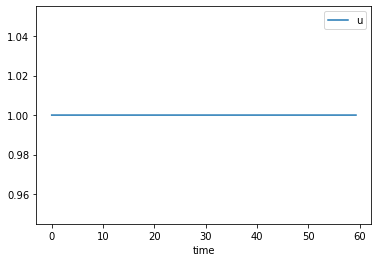

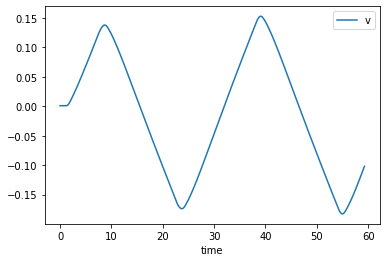

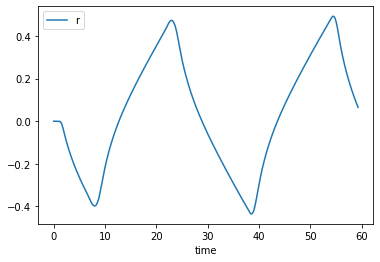

In [36]:
df_ = df.copy()
t = df_.index
control = df_[['delta']]
#control = {'delta':0,}


parameters = dict(df_parameters['prime'])

df_0 = df_.iloc[0]
y0 = {
    'u' : df_0['u'], 
    'v' : df_0['v'],
    'r' : df_0['r'],
    'x0' : df_0['x0'],
    'y0' : df_0['y0'],
    'psi' : df_0['psi'],
    }

#solution = model.simulate(y0=y0, t=t, df_parameters=df_parameters, df_ship_parameters=df_ship_parameters, control=control, rtol=1e-3, atol=1e-3)
solution = model.simulate(y0=y0, t=t, df_parameters=df_parameters, ship_parameters=ship_parameters, control=control)

columns = list(y0.keys())
df_result_prime = pd.DataFrame(data=solution.y.T, columns=columns)
df_result_prime.index=t[0:len(df_result_prime)]

#df_result_prime['U'] = np.sqrt(df_result_prime['u']**2 + df_result_prime['v']**2)

df_result_prime.plot(y='u')
df_result_prime.plot(y='v')
df_result_prime.plot(y='r')


In [37]:
#units = {key:value[1] for key,value in zip(columns,y0)}
import numpy as np
U_ = np.sqrt(df_0['u']**2 + df_0['v']**2)
df_result = ps.unprime(values=df_result_prime, U=U_)
df_result['beta'] = -np.arctan2(df_result['v'],df_result['u'])

<AxesSubplot:xlabel='time'>

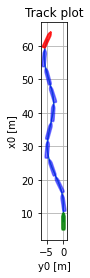

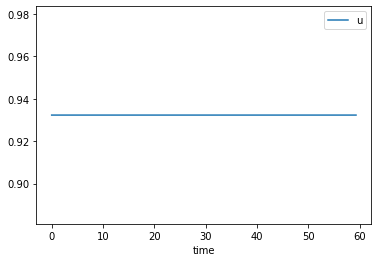

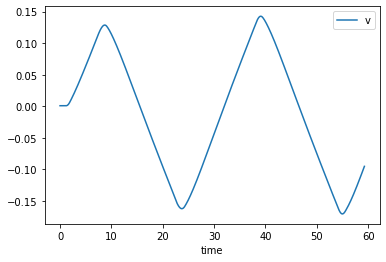

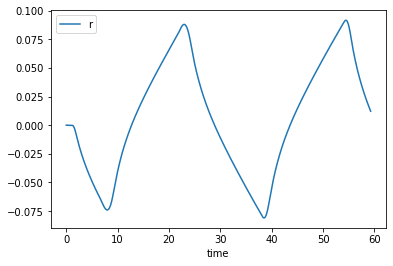

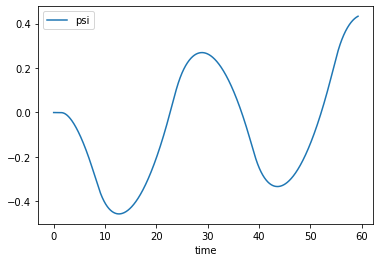

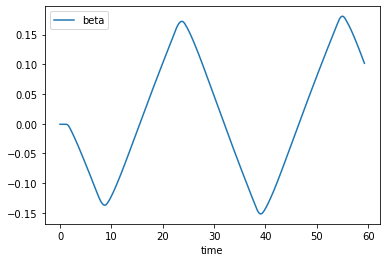

In [38]:
track_plot(df=df_result, lpp=ship_parameters['L'], beam=ship_parameters['B'])

df_result.plot(y='u')
df_result.plot(y='v')
df_result.plot(y='r')
df_result.plot(y='psi')
df_result.plot(y='beta')

